# Análisis de Sentimientos
Trabajo de procesamiento de lenguaje natural analizando los sentimientos de titulares de páginas de información.

Realizado por:
- Hugo Peralta Muñoz
- Tristán Del Rosal Aguirre

## Importación de librerías

In [ ]:
# Usaremos requests para hacer las peticiones a las páginas web
import requests

# Importaremos las librerías de utilidades y de gráficas que utilizaremos a lo largo del proyecto
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# La librería de Beautiful Soup es la que emplearemos para hacer web scrapping
from bs4 import BeautifulSoup

# Con pipeline cargaremos el modelo que se encargará de realizar el análisis de sentimientos
from transformers import pipeline

# Tratamiento del lenguaje natural
import nltk
from nltk.corpus import stopwords
import re

Con el siguiente bloque de código ajustaremos el límite de carácteres que tiene por defecto pandas y lo eliminaremos.

In [ ]:
pd.set_option('display.max_colwidth', None)

## Carga del modelo a utilizar en el análisis de sentimientos

El modelo que emplearemos será el *bert base multilingual uncased sentiment* con el cuál podremos hacer análisis de páginas webs de distintos idiomas, incluyendo el español, el cual es el que nos centraremos en este proyecto.

El modelo lo podremos ubicar en este
<a href="https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment">link</a>, donde veremos que aunque el Español sea el que menos datos de entrenamientos tenemos, al ser revisado por un humano es de los que mejor porcentaje de aciertos muestra.

Mediante la librería importada anteriormente, `pipeline` cargaremos nuestro clasificador.

In [ ]:
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Extracción de los titulares de los portales de noticias

Crearemos un método para extraer los elementos `html` que queramos de las páginas webs que buscaremos, en nuestro caso solo sacaremos los `h2` ya que son los que usan los portales de noticia para mostrar el titular de las distintas noticias.

In [ ]:
def get_headers(url):
  response = requests.get(url)

  if response.status_code != 200:
    print(f"Error al acceder a {url}")
    return []

  bs = BeautifulSoup(response.text, "html.parser")
  headers = bs.find_all(["h2"])

  if not headers:
    print(f"No se encontraron encabezados en {url}")
    return []

  return [header.text.strip() for header in headers if header.text.strip()]

Ahora preparamos un diccionario con el nombre y la URL de los portales de noticias de los cuales querremos extraer los titulares.

In [ ]:
paginas_webs_mas_vistas_en_espana = {
    "El Pais": "https://elpais.com/",
    "El Mundo": "https://www.elmundo.es/",
    "Marca": "https://www.marca.com/",
    "El Diario": "https://www.eldiario.es/",
    "AS": "https://as.com/",
    "La Vanguardia": "https://www.lavanguardia.com/",
    "Hola": "https://www.hola.com/",
    "Malaga Hoy": "https://www.malagahoy.es/",
    "Expansion": "https://www.expansion.com/",
    "Vandal": "https://vandal.elespanol.com/"
}

Crearemos un bucle por el cual extraeremos todos los titulares de las distintas páginas que tenemos almacenadas para guardarlos en un diccionario, de forma que tendremos los titulares con la página de los que han sido extraídos.

In [ ]:
# Creamos un diccionario con los nombres del portal de noticias junto a todos sus headers
headers_dict = {}

for pagina, url in paginas_webs_mas_vistas_en_espana.items():
    headers = get_headers(url)
    if headers:
        headers_dict[pagina] = headers

Prepararemos un dataframe para almacenar los resultados, donde guardaremos por una parte el titular y por otra de qué página se ha extraido.

In [ ]:
# Transformamos las noticias a un dataframe
data = []

for pagina, headers in headers_dict.items():
    for header in headers:
        data.append({"Pagina": pagina, "Encabezado": header})

df = pd.DataFrame(data)

Para ver los datos con los que contamos crearemos una gráfica con la cantidad de titulares extraídos de cada páginas.

<ipython-input-8-3edac86723a9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Pagina", y="Encabezado", data=pagina_counts, palette="viridis")


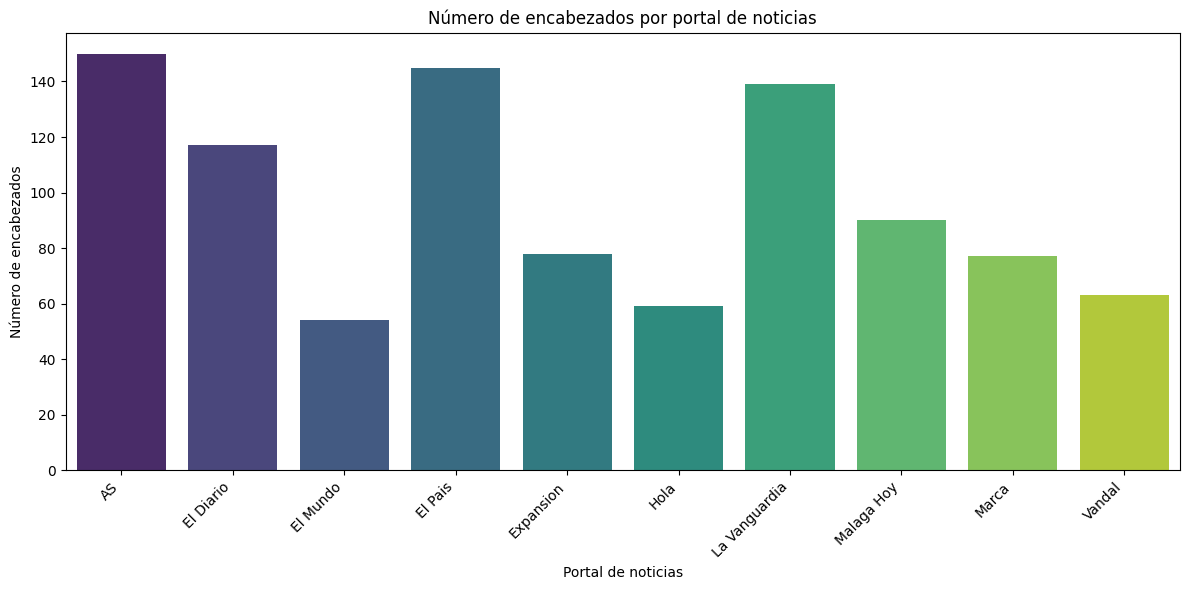

In [ ]:
pagina_counts = df.groupby("Pagina")["Encabezado"].count().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x="Pagina", y="Encabezado", data=pagina_counts, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Número de encabezados por portal de noticias")
plt.xlabel("Portal de noticias")
plt.ylabel("Número de encabezados")
plt.tight_layout()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Pagina      972 non-null    object
 1   Encabezado  972 non-null    object
dtypes: object(2)
memory usage: 15.3+ KB


Podemos ver que prácticamente contamos con cerca de 1000 titulares de distintas noticias.

## Análisis y clasificaciones del modelo

El modelo *bart-base-multilingual-uncased-sentiment* a la hora de hacer una predicción nos devolverá un diccionario, con el siguiente formato:

```Python
result = {'label': '3 stars', 'score': 0.25504210591316223}
```
Por un lado nos devuelve un `score` que no es más que una puntuación de la probabilidad que tiene de ser una de las 5 estrellas.

Además de esto, nos devuelve un número de estrella, cuyo score es más alto, indicando desde si es más negativo el titular (1 estrella) a si es más positivo nuestro titular (5 estrellas). Haciendo pruebas con nuestro modelo pudimos comprobar que las estrellas intermedias solían ser titulares bastante neutros y que no equivalen sólo a que sean un poco menos negativas, sino que realmente no podríamos tomarla en ninguno de los bandos.

Debido a esto, trataremos las estrellas intermedias (2 estrellas, 3 estrellas y 4 estrellas) como titulares neutros.

Para ello, realizaremos un método que haga la predicción de cada titular y devuelva según el número de estrellas que presenta si es negativo, positivo o neutro.

In [ ]:
def classify_sentiment(text):
    result = classifier(text) # Hacemos la prediccion del texto que pasamos
    stars = int(result[0]["label"].split()[0]) # Sacamos las estrellas que tiene la prediccion

    if stars == 1:
        return "negativo"
    elif stars == 5:
        return "positivo"
    else:
        return "neutro"

Ahora guardamos la clasificación de cada uno de los titulares en el dataframe.

In [ ]:
df["Sentimiento"] = df["Encabezado"].apply(classify_sentiment) # Aplicamos el metodo a todas las filas

In [ ]:
df.head(20)

,Pagina,Encabezado,Sentimiento
0,El Pais,Miles de migrantes afrontan el temor de celebrar su última cena de Acción de Gracias por miedo a ser deportados,positivo
1,El Pais,Los aranceles con los que el magnate amenaza a México y Canadá costarán 1.300 dólares anuales a los hogares de Estados Unidos,negativo
2,El Pais,Sheinbaum y Trump ponen a prueba sus límites,positivo
3,El Pais,Zuckerberg se reúne con el presidente electo en Florida tras años de enfrentamientos entre ambos,neutro
4,El Pais,Modesto Flako Jiménez: “Quiero invitar a los mayores a contar sus historias y no esperar a que las descubramos en una caja”,neutro
5,El Pais,Más de 10.000 libros han sido prohibidos en bibliotecas públicas y académicas de Estados Unidos,negativo
6,El Pais,Cómo cayó M.I.A.: crónica de la artista comprometida y radical que acabó apoyando a Trump y los antivacunas,positivo
7,El Pais,Cómo y dónde ver el Desfile del Día de Acción de Gracias de Macy’s,positivo
8,El Pais,‘Thanksgiving’ y los nativos americanos: una historia complicada,neutro
9,El Pais,Cómo y dónde ver los juegos de la NFL en el Día de Acción de Gracias 2024,positivo


## Visualización de distintas gráficas sobre los resultados obtenidos

Vamos a mostrar ahora una gráfica para visualizar cuantas noticias positivas, negativas y neutras ofrecen las distintas webs de noticias que hemos usado en nuestra predicción.

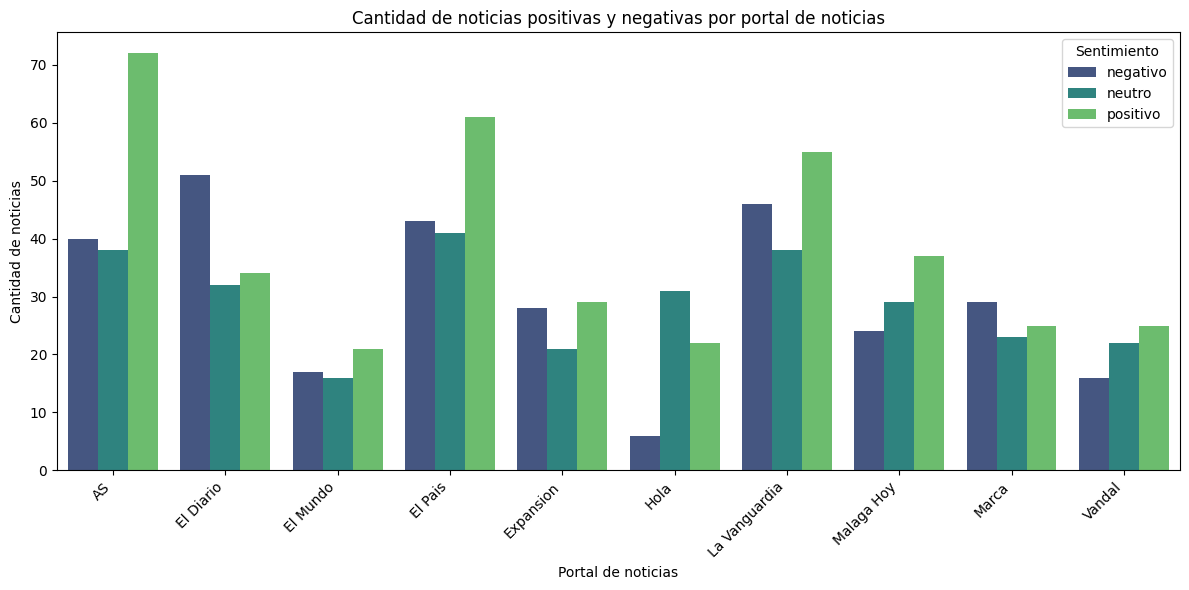

In [ ]:
sentimientos_por_pagina = df.groupby(["Pagina", "Sentimiento"])["Sentimiento"].count().reset_index(name="Cantidad")

plt.figure(figsize=(12, 6))

sns.barplot(x="Pagina", y="Cantidad", hue="Sentimiento", data=sentimientos_por_pagina, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Cantidad de noticias positivas y negativas por portal de noticias")
plt.xlabel("Portal de noticias")
plt.ylabel("Cantidad de noticias")

plt.tight_layout()
plt.show()

Podremos realizar también una gráfica que nos muestre el porcentaje de predicciones de titulares positivos, negativos y neutros que tenemos en nuestro dataset.

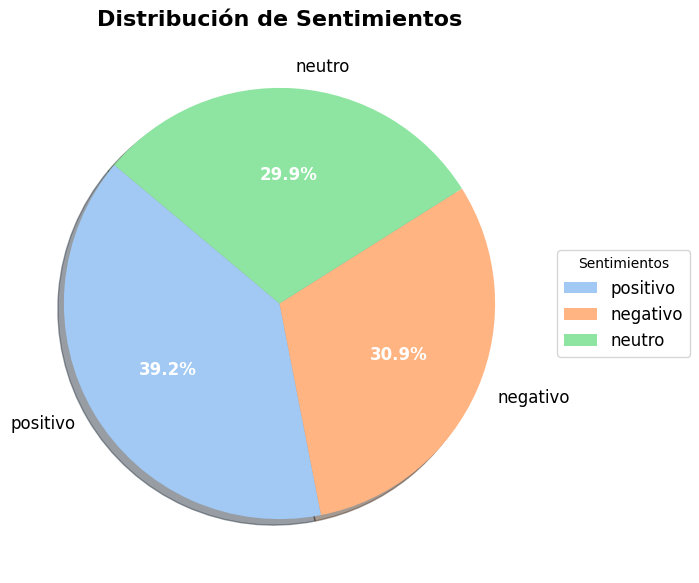

In [ ]:
sentimientos_counts = df['Sentimiento'].value_counts()

colores = sns.color_palette("pastel", len(sentimientos_counts))

plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(
    sentimientos_counts,
    labels=sentimientos_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colores,
    shadow=True,
    textprops={'color': 'black', 'fontsize': 12}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.legend(
    wedges,
    sentimientos_counts.index,
    title="Sentimientos",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12
)

plt.title('Distribución de Sentimientos', fontsize=16, fontweight='bold')

plt.show()

## Procesamiento del lenguaje natural

Haremos usos de varias técnicas como eliminación de las `stop words` y la reordenación de los textos basados en los sentimientos que provocan para lograr sacar gráficas del estilo *nube de palabras (O word cloud)* y observar las palabras más repetidas según el sentimiento que transmite.

Primero eliminaremos las `stop words`.

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Crearemos un método para limpiar los titulares

In [ ]:
def limpiar_texto(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales y dígitos
    text = re.sub(r"[^a-záéíóúüñ\s]", "", text)
    # Dividir palabras y eliminar stop words
    palabras = [word for word in text.split() if word not in stop_words]
    return " ".join(palabras)

In [ ]:
texto_positivo = " ".join(limpiar_texto(encabezado) for encabezado in df[df["Sentimiento"] == "positivo"]["Encabezado"])
texto_negativo = " ".join(limpiar_texto(encabezado) for encabezado in df[df["Sentimiento"] == "negativo"]["Encabezado"])
texto_neutro = " ".join(limpiar_texto(encabezado) for encabezado in df[df["Sentimiento"] == "neutro"]["Encabezado"])

Crearemos de la misma forma un método para visualizar en forma de `Word Clouds` los distintos textos basados en el sentimiento que transmiten.

In [ ]:
def generar_nube_de_palabras(texto, titulo):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="viridis",
        max_words=100
    ).generate(texto)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo, fontsize=16, fontweight="bold")
    plt.show()

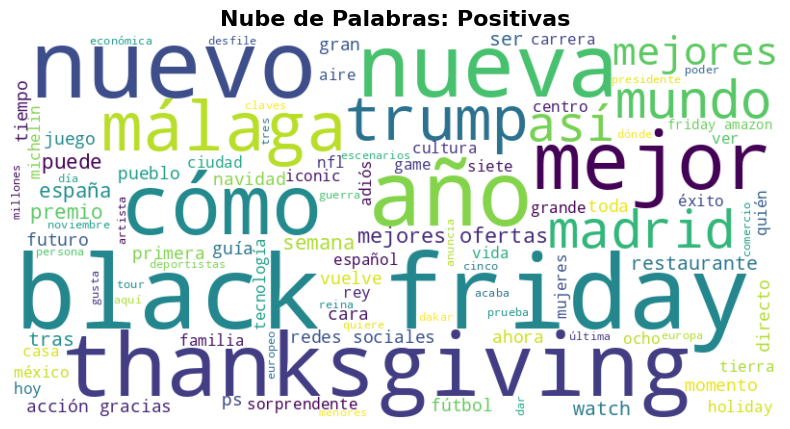

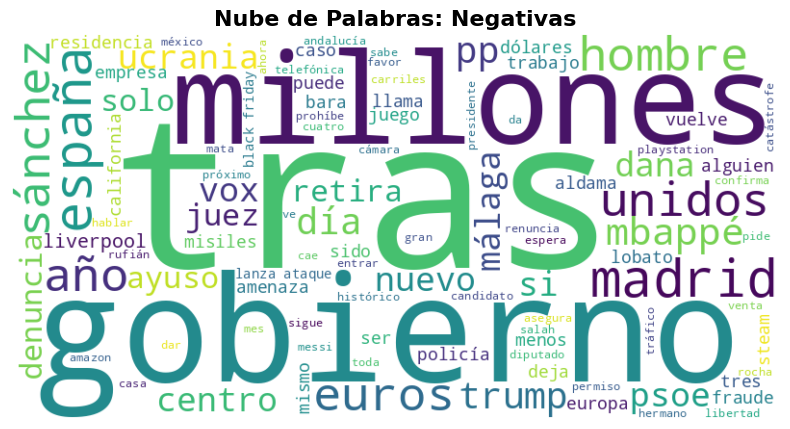

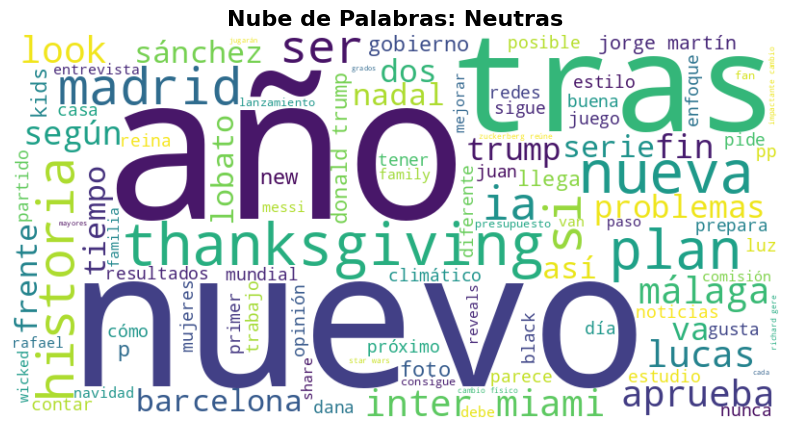

In [ ]:
generar_nube_de_palabras(texto_positivo, "Nube de Palabras: Positivas")
generar_nube_de_palabras(texto_negativo, "Nube de Palabras: Negativas")
generar_nube_de_palabras(texto_neutro, "Nube de Palabras: Neutras")